## This Notebook is tasked with learning the kernel from some pinhole data. 
#### We do it in two stages. First we apply an affine transform model to get the kernel in the right location. Then we make regions of the kernel trainable and do further training. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
from models.custom.modules import *
import forward.fourier.method as fwd

from forward.fourier.kernel_creator import *
import scipy.ndimage
from skimage.transform import rotate

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2
device = 'cuda:1'

desired_range = [750,850]
desired_channels = 25

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


## Go from nograting cube to grating cube with grad descent


In [2]:
def WienerDeconvolution(final, kernel, lamb = 0.001):
    
    nc = kernel.shape[-1]
    padder = [[0,0]]*(len(kernel.shape) -1) + [[nc//2,nc//2]]
    
    # kernel = np.fft.fftshift(kernel)

    
    kernelpad = np.pad(kernel,padder)
    finalpad = np.pad(final,padder)
    
    kernel_fft = np.fft.fft(kernelpad,axis=-1)
    final_fft = np.fft.fft(finalpad,axis=-1)

    original_fft=(np.conj(kernel_fft)*final_fft)/ (np.square(np.abs(kernel_fft))+ lamb)


    original = np.abs(np.fft.ifftshift(np.fft.ifft(original_fft,axis=-1),axes=-1))

    original = original[...,nc//2:-(nc//2)]

    return original

def create_conv_matrix(template,kernelsize=11):
    '''
    create the convolutional matrix to be used with leastsq for calcpsfkernel. 
    template is the detector image, kernel size is the size of the psf kernel, points is the points of which to calculate 
    '''

    #each row in matrix is multiplied by the psf kernel. the psf kernel acts on only the 11x11 elements around the central element. Therefore
    #each row must have the 11x11 elements around the central one.

    if kernelsize%2==0:
        raise ValueError('kernelsize must be odd')

    border = int(kernelsize//2)
    shape = template.shape
    M = np.zeros((shape[0] * shape[1],kernelsize**2))

    region = np.zeros((shape[0] + kernelsize,shape[1]+kernelsize))
    region[border+1:-border,border+1:-border] = template


    for i in range(shape[0]):
        for j in range(shape[1]):    
            x,y = i+border+1, j+border +1
            
            M[i * shape[1] + j] = region[x-(border):x+(border)+1,y-(border):y+(border)+1].flatten()

    return M

def calc_psf_kernel(result,mask,kernelsize=11):
    '''
    result is the blurred mask we see in camera
    mask is the true mask
    '''

    result = result.flatten() #this is the result (c)
    #we wish to find the psf, h, which is c = h (conv) m

    #first lets decide dimensions of our psf kernel. Lets say 11x11. therefore 121 elements. Now create conv matrix

    M = create_conv_matrix(mask,kernelsize)

    # M += np.random.rand(*M.shape) * 0.000000001


    #now least squares
    psf = np.linalg.inv(M.T@M)@M.T @ result
    
    return psf.reshape((kernelsize,kernelsize))


dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20231016_Monochromator/'


In [3]:


mask_nograting_cube = torch.load(dir + 'mask_cube_nograting.pt').to(torch.float32).to(device)


In [4]:
from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass,shift


In [5]:
peaks = peak_local_max(mask_nograting_cube[0,11].cpu().numpy(), min_distance=6,threshold_rel=0.1)

In [6]:
peaks

array([[ 304, 1259],
       [ 394, 1364],
       [ 349, 1378],
       ...,
       [ 216, 1080],
       [ 551, 1229],
       [ 334, 1440]])

In [7]:
boxsize = 10

wl = mask_nograting_cube.shape[1]

com_peaks = np.zeros((len(peaks),wl,2),dtype=np.float32)
extracted_peaks = np.zeros((len(peaks), wl, boxsize,boxsize))
simulated_peaks = np.zeros_like(extracted_peaks)
simulated_peaks[:,:,boxsize//2-1:boxsize//2+1,boxsize//2-1:boxsize//2+1] =1

kernelsize = 9

psfs = np.zeros((len(peaks),kernelsize,kernelsize))

for l in range(wl):
    for n,peak in enumerate(peaks):
        print(n/len(peaks),l,end='\r')

        extracted_peaks[n,l] = mask_nograting_cube[0,l,peak[0]-boxsize//2:peak[0]+boxsize//2,peak[1]-boxsize//2:peak[1]+boxsize//2].cpu().numpy()
        thresholded = extracted_peaks[n,l].copy()
        thresholded[thresholded<0.05*thresholded.max()] = 0

        com_peaks[n,l] = np.array(center_of_mass(thresholded)) - (boxsize//2  - 0.5)



        simulated_peaks[n,l] = shift(simulated_peaks[n,l],com_peaks[n,l]  ,order=1)  
        simulated_peaks[n,l] *=  extracted_peaks[n,l].mean() / simulated_peaks[n,l].mean()

        com_peaks[n,l] += peak


    # psfs[n] = calc_psf_kernel(extracted_peaks[n],simulated_peaks[n],kernelsize=kernelsize)




3.041401427239521e-07 3.041401427239521e-07


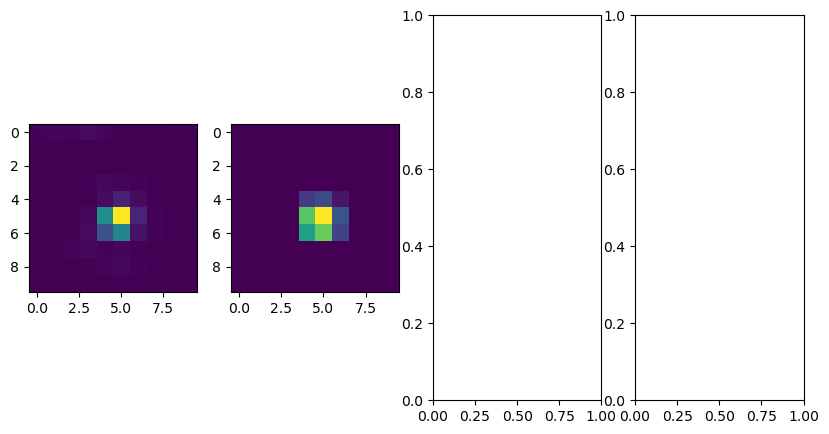

In [8]:
l=11

i = np.random.randint(len(peaks))
fig,ax = plt.subplots(1,4,figsize=(10,5))
ax[0].imshow(extracted_peaks[i,l])
ax[1].imshow(simulated_peaks[i,l])

print(extracted_peaks[i,l].mean(),simulated_peaks[i,l].mean())  


In [9]:
# mask = simulated_peaks[0]

# M = create_conv_matrix(mask,kernelsize)

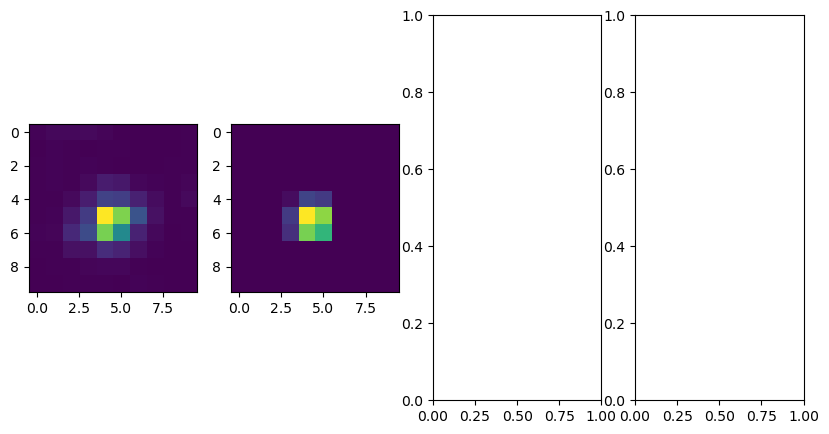

In [10]:
l=0

i = np.random.randint(len(peaks))
# reconstruction = torch.nn.functional.conv2d(torch.from_numpy(simulated_peaks[None,i:i+1]).to(torch.float32),torch.from_numpy(psfs[None,i:i+1]).to(torch.float32),stride=1,padding=4).squeeze()
fig,ax = plt.subplots(1,4,figsize=(10,5))
ax[0].imshow(extracted_peaks[i,l])
ax[1].imshow(simulated_peaks[i,l])
# ax[2].imshow(psfs[i])
# ax[3].imshow(reconstruction.detach().cpu().numpy())

### CoM Training

Lets begin with a map of 2d mask pixels. The model is allowed to rotate them and shift them in order to match the data as best as possible.

In [11]:
mask_funda_wl = mask_nograting_cube[:,:,100:600,1000:1500]

mask_funda = mask_funda_wl.sum(1).unsqueeze(1)


peaks = peak_local_max(mask_funda[0,0].cpu().numpy(), min_distance=6,threshold_rel=0.1)

In [12]:
l=0

distances = np.zeros((len(peaks),len(peaks)))
for i in range(len(peaks)):
    for j in range(len(peaks)):
        distances[i,j] = np.linalg.norm(peaks[i] - peaks[j])

In [13]:
distances[distances<5] = np.inf

In [14]:

bla = distances[0].argmin()

angle = np.arctan2((peaks[0,0] - peaks[bla,0]) , (peaks[0,1] - peaks[bla,1]))

In [15]:

init_guess = torch.zeros_like(mask_funda)

peaks = peaks[::3]

peak = peaks[0]

i,j = peak
while i > 0:
    while j>0:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j -= 8
    j = peak[1]
    while j < mask_funda.shape[-1]:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j += 8
    j = peak[1]


    i -= 8

i,j = peak
while i < mask_funda.shape[-2]:
    while j>0:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j -= 8
    j = peak[1]
    while j < mask_funda.shape[-1]:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j += 8
    j = peak[1]
    i += 8


# init_guess[:,:,peaks[0,0] - 1:peaks[0,0]+1,peaks[0,1]-1:peaks[0,1]+1] = 1

Text(0.5, 1.0, 'initial guess')

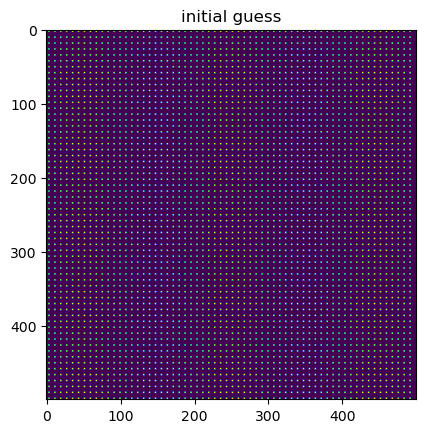

In [16]:
plt.imshow(init_guess[0,0].cpu()); plt.title('initial guess')

In [17]:
kernelsize = 9

regions = np.zeros((len(peaks),2,2))

regions[:,0,0] = peaks[:,0] - kernelsize//2
regions[:,0,1] = peaks[:,0] + kernelsize//2
regions[:,1,0] = peaks[:,1] - kernelsize//2
regions[:,1,1] = peaks[:,1] + kernelsize//2

# regions[:,0] = regions[:,0] - 100
# regions[:,1] = regions[:,1] - 1000

regions = torch.tensor(regions,dtype=torch.int)




In [18]:
# loss_fn = CenterOfMassLoss(regions,funda_weight=1,intensity_factor=2, channels=mask_grating_cube.shape[1])
loss_fn = CenterOfMassLoss(regions,funda_weight=1,intensity_factor=2, channels=1)

# model = AffineTransformModel(region = regions,rot = 45.,transX=0.,transY=0.,scale = True, no_channels = 1).to(device)
model = AffineTransformModel(region = np.array([[[0,mask_funda.shape[2]],[0,mask_funda.shape[3]]]]),rot = -np.rad2deg(angle),transX=0.12,transY=0.14,scale = False, no_channels = 1, grating=False).to(device)

In [19]:
# model = torch.nn.Conv2d(1,1,kernel_size=9,padding=4,bias=False).to(device)

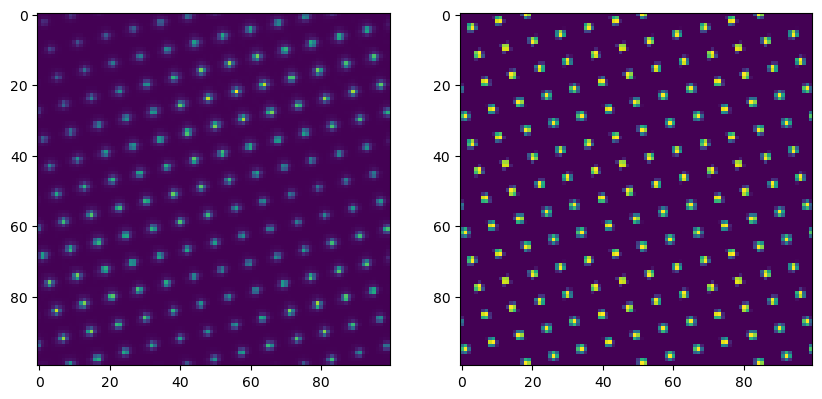

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(mask_funda.cpu()[0,0,100:200,100:200])

ax[1].imshow(model(init_guess).detach().cpu()[0,0,100:200,100:200])

In [21]:
# init_guess += 0.0001*torch.rand_like(init_guess)

In [17]:
loss_fn(model(init_guess),mask_funda)

tensor(2.6287, device='cuda:1', grad_fn=<DivBackward0>)

In [18]:
init_guess.shape

torch.Size([1, 1, 500, 500])

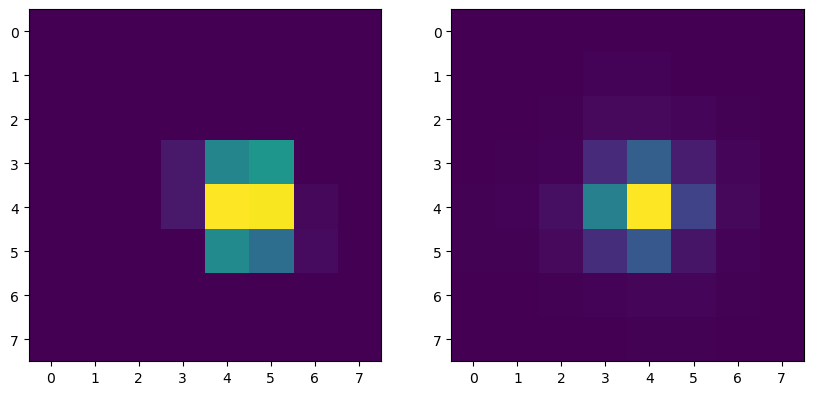

In [19]:
bla = regions[0]
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(model(init_guess)[0,0,bla[0,0]:bla[0,1], bla[1,0]:bla[1,1]].detach().cpu())
ax[1].imshow(mask_funda[0,0,bla[0,0]:bla[0,1], bla[1,0]:bla[1,1]].detach().cpu())

In [20]:
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['mse'] = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

epochs = 300
start_time_sec = time.time()
num_train_examples = 1

for epoch in range(1, epochs+1):
    torch.cuda.empty_cache()


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()


    adjusted = model(init_guess)
    
    
    loss =  loss_fn(adjusted, mask_funda)
    # loss =  loss_fn2(yhat, grating_cube)  

    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() 





    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}: , train loss: {(train_loss/num_train_examples):5.5g}, train mse: {(num_train_examples):5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['loss'].append(train_loss)


KeyboardInterrupt: 

In [21]:
print(model.rot_list, angle)

Parameter containing:
tensor([-1.3295], device='cuda:1', dtype=torch.float64, requires_grad=True) 1.3258176636680326


Text(0.5, 1.0, 'affine model result')

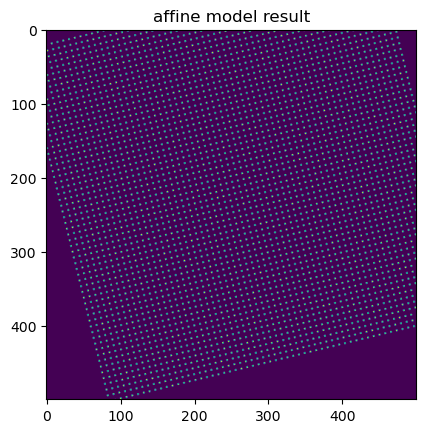

In [22]:
plt.imshow(adjusted[0,0].detach().cpu()); plt.title('affine model result')

In [23]:
peaks = peak_local_max(mask_funda[0,0].detach().cpu().numpy(), min_distance=6,threshold_rel=0.03)

In [26]:
wl = 25

In [27]:
final_prediction = torch.zeros_like(adjusted).tile(1,wl,1,1)

bord = 4

for l in range(wl):
    for peak in peaks:
        synthetic = adjusted[0,0,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord].detach().cpu()
        true = mask_funda_wl[0,l,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord].detach().cpu()

        final_prediction[:,l,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord] = synthetic   *   ( true.sum() / 4)#synthetic.sum())

Text(0.5, 1.0, 'true')

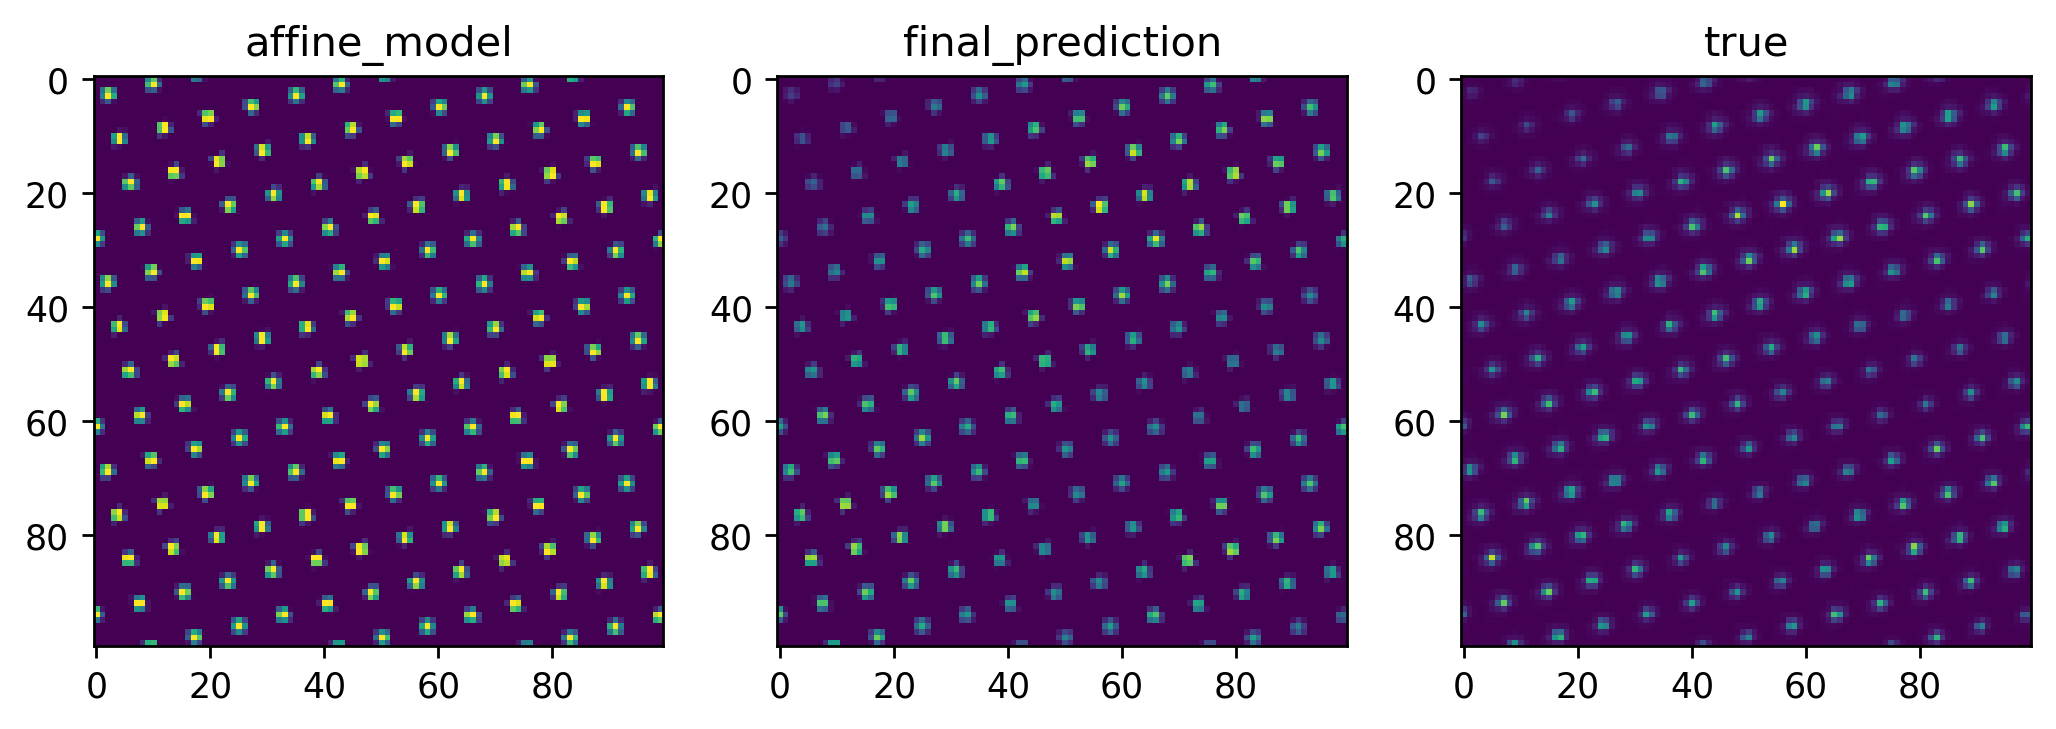

In [28]:
fig,ax = plt.subplots(1,3   ,figsize=(10,5),dpi=250)
ax[0].imshow(adjusted[0,0,100:200,100:200].detach().cpu()); ax[0].set_title('affine_model')
ax[1].imshow(final_prediction.cpu()[0,10,100:200,100:200]);ax[1].set_title('final_prediction')
ax[2].imshow(mask_funda_wl[0,10,100:200,100:200].detach().cpu());ax[2].set_title('true')

Text(0.5, 1.0, 'final_prediction')

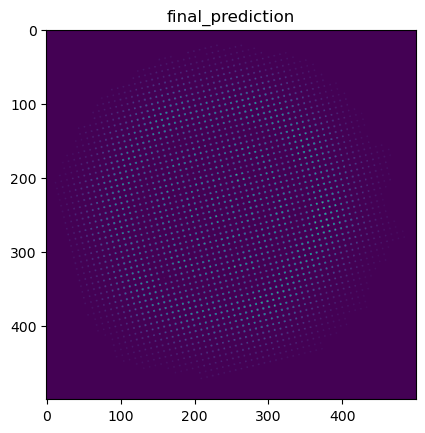

In [29]:
plt.imshow(final_prediction[0,11].detach().cpu()); plt.title('final_prediction')

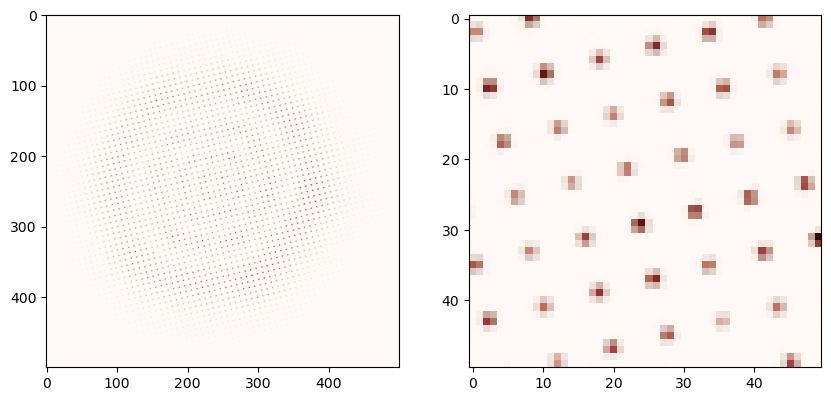

In [30]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(final_prediction[0,10].cpu(),cmap='Greys') 
ax[0].imshow(mask_funda_wl[0,10].cpu(),cmap='Reds',alpha=0.5)
ax[1].imshow(final_prediction[0,10,200:250,200:250].cpu(),cmap='Greys') 
ax[1].imshow(mask_funda_wl[0,10,200:250,200:250].cpu(),cmap='Reds',alpha=0.5)

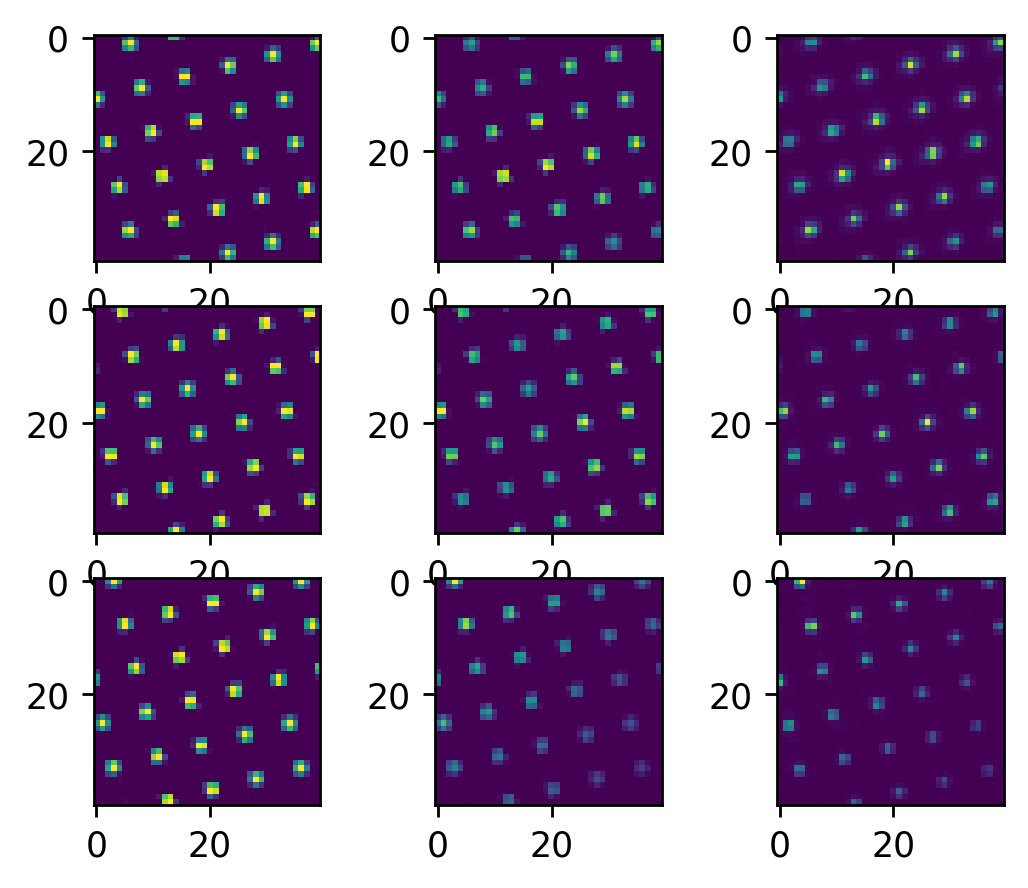

In [31]:
fig,ax = plt.subplots(3,3   ,figsize=(5,4),dpi=250)
ax[0,0].imshow(adjusted[0,0,160:200,160:200].detach().cpu())
ax[0,1].imshow(final_prediction.cpu()[0,10,160:200,160:200])
ax[0,2].imshow(mask_funda_wl[0,10,160:200,160:200].detach().cpu())
ax[1,0].imshow(adjusted[0,0,260:300,260:300].detach().cpu())
ax[1,1].imshow(final_prediction.cpu()[0,10,260:300,260:300])
ax[1,2].imshow(mask_funda_wl[0,10,260:300,260:300].detach().cpu())
ax[2,0].imshow(adjusted[0,0,360:400,360:400].detach().cpu())
ax[2,1].imshow(final_prediction.cpu()[0,10,360:400,360:400])
ax[2,2].imshow(mask_funda_wl[0,10,360:400,360:400].detach().cpu())

In [32]:
final_prediction *= mask_funda_wl.mean() / final_prediction.mean() 

In [33]:
groundtruth = torch.zeros_like(mask_nograting_cube).to('cpu')
groundtruth[:,:,100:600,1000:1500] = final_prediction
torch.save(groundtruth,dir + 'groundtruth.pt')

################

In [593]:
final_prediction = torch.load(dir + 'groundtruth.pt').to(device)[...,100:600,1000:1500]

In [594]:
CG_channels = 9
kernelsize = 3

final_prediction = final_prediction / final_prediction.mean()
mask_funda_wl = mask_funda_wl / mask_funda_wl.mean()


# initialiser = torch.rand((1,CG_channels,mask_nograting_funda.shape[2],mask_nograting_funda.shape[3]))
initialiser = torch.ones((1,CG_channels,mask_funda.shape[2],mask_funda.shape[3]))
initialiser = initialiser / CG_channels

CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=True, three_d=False).to(device) 



In [595]:
def initialise_LCN_map(size,angle_degrees):
    '''
    For a given direction, make a linear map in that direction.
    '''

    angle_radians = np.deg2rad(angle_degrees)
    
    # Calculate the x and y components of the gradient
    x_gradient = np.cos(angle_radians)
    y_gradient = np.sin(angle_radians)
    
    # Create a meshgrid for the x and y coordinates
    x_indices = torch.linspace(0, x_gradient, size[0])
    y_indices = torch.linspace(0, y_gradient, size[1])
    x_grid, y_grid = torch.meshgrid(x_indices, y_indices)
    
    # Calculate the gradient array
    gradient_array = x_grid + y_grid

    gradient_array = gradient_array / gradient_array.max()    * (1/9) 
    print(gradient_array.mean())
    
    return gradient_array
    
CG_conv.CG.map.data[:,0] = initialise_LCN_map(mask_funda.shape[2:],45)
CG_conv.CG.map.data[:,1] = initialise_LCN_map(mask_funda.shape[2:],0)
CG_conv.CG.map.data[:,2] = torch.flip(initialise_LCN_map(mask_funda.shape[2:],45),dims=(-1,))
CG_conv.CG.map.data[:,3] = torch.rot90(initialise_LCN_map(mask_funda.shape[2:],0),dims=(-2,-1))
CG_conv.CG.map.data[:,5] = torch.rot90(initialise_LCN_map(mask_funda.shape[2:],0),dims=(-1,-2))
CG_conv.CG.map.data[:,6] = torch.rot90(initialise_LCN_map(mask_funda.shape[2:],45),dims=(-2,-1))
CG_conv.CG.map.data[:,7] = torch.flip(initialise_LCN_map(mask_funda.shape[2:],0),dims=(-2,))
CG_conv.CG.map.data[:,8] = torch.rot90(initialise_LCN_map(mask_funda.shape[2:],45),k=2,dims=(-1,-2))

CG_conv.CG.map.data[:,4] = 1/9


tensor(0.0556)
tensor(0.0556)
tensor(0.0556)
tensor(0.0556)
tensor(0.0556)
tensor(0.0556)
tensor(0.0556)
tensor(0.0556)


In [596]:
loss_fn(mask_funda_wl, final_prediction),loss_fn(mask_funda_wl[:,11:12], final_prediction[:,11:12])

(tensor(7.8997, device='cuda:1'), tensor(11.3077, device='cuda:1'))

In [597]:


def first_deriv(map,norm=2):
    #map is shape bs,nc,nx,ny
    first_deriv_x, first_deriv_y = torch.gradient(map,axis=(2,3))

    reg_loss = torch.norm(torch.concat([first_deriv_x,first_deriv_y],dim=0),p=norm)
    
    first_deriv_x2 = map[...,1:,:] - map[...,:-1,:]
    first_deriv_y2 = map[...,:,1:] - map[...,:,:-1]
    reg_loss2 = torch.norm(torch.concat([first_deriv_x2,first_deriv_y2.permute(0,1,3,2)],dim=0),p=norm)

    return reg_loss + 0.8 * reg_loss2


def calc_second_derivs2D(map):
    first_deriv_x, first_deriv_y = torch.gradient(map,axis=(2,3))
    second_deriv_xx, second_deriv_xy = torch.gradient(first_deriv_x,axis=(2,3))
    second_deriv_yx, second_deriv_yy = torch.gradient(first_deriv_y,axis=(2,3))
    return second_deriv_xx, second_deriv_xy, second_deriv_yx, second_deriv_yy



def hessian(map,norm=2):
    deriv_xx = (1/90)*torch.roll(map,3,dims=2) -(3/20)*torch.roll(map,2,dims=2) + (3/2)*torch.roll(map,1,dims=2) - (49/18) * map + (3/2)*torch.roll(map,-1,dims=2) - (3/20)*torch.roll(map,-2,dims=2) + (1/90)*torch.roll(map,-3,dims=2)
    deriv_yy = (1/90)*torch.roll(map,3,dims=3) -(3/20)*torch.roll(map,2,dims=3) + (3/2)*torch.roll(map,1,dims=3) - (49/18) * map + (3/2)*torch.roll(map,-1,dims=3) - (3/20)*torch.roll(map,-2,dims=3) + (1/90)*torch.roll(map,-3,dims=3)
    deriv_xy = (1/90)*torch.roll(map,(3,3),dims=(2,3)) -(3/20)*torch.roll(map,(2,2),dims=(2,3)) + (3/2)*torch.roll(map,(1,1),dims=(2,3)) - (49/18) * map + (3/2)*torch.roll(map,(-1,-1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,-2),dims=(2,3)) + (1/90)*torch.roll(map,(-3,-3),dims=(2,3))
    deriv_yx = (1/90)*torch.roll(map,(3,-3),dims=(2,3)) -(3/20)*torch.roll(map,(2,-2),dims=(2,3)) + (3/2)*torch.roll(map,(1,-1),dims=(2,3)) - (49/18) * map + (3/2)*torch.roll(map,(-1,1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,2),dims=(2,3)) + (1/90)*torch.roll(map,(-3,3),dims=(2,3))

    deriv_xx = deriv_xx[:,:,3:-3,3:-3]
    deriv_yy = deriv_yy[:,:,3:-3,3:-3]
    deriv_xy = deriv_xy[:,:,3:-3,3:-3]
    deriv_yx = deriv_yx[:,:,3:-3,3:-3]


    reg_loss = torch.norm(torch.concat([deriv_xx,deriv_xy,deriv_yx,deriv_yy],dim=0),p=norm)
    return reg_loss



In [608]:
batch_x = torch.zeros((16,final_prediction.shape[1],final_prediction.shape[2],final_prediction.shape[3])).to(device)
batch_y = torch.zeros((16,final_prediction.shape[1],final_prediction.shape[2],final_prediction.shape[3])).to(device)

for i in range(16):
    x = (i//4) * 2
    y = (i%4) * 2
    batch_x[i] = torch.roll(final_prediction[0],(x,y),(1,2))
    batch_y[i] = torch.roll(mask_funda_wl[0],(x,y),(1,2))


In [609]:
for i in range(16):
    x = i//4
    y = i%4
    print(x,y)

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


In [610]:
history2= {}
history2['tl'] = []
history2['mse'] = []
history2['reg'] = []
history2['lr'] = []

In [618]:
lr = 5e-3



epochs = 8000
init_reg_factor = 5e-3

wl=11

all_params = list(CG_conv.parameters())

optimizer = torch.optim.Adam(all_params, lr=lr)


In [619]:
start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    yhat = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(final_prediction.shape[1])],dim=1)



    reg = hessian(CG_conv.CG.map,norm=1)


    mse = loss_fn(yhat,batch_y)
    loss =  mse + reg * init_reg_factor

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for n,parameter in enumerate(CG_conv.parameters()):
            # parameter.clamp_(min=0)
            if n!=2:
                # parameter.clamp_(min=0,max=1)
                parameter.clamp_(min=0)
            # else:
                # parameter.clamp_(max=1)

    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')


    history2['tl'].append(train_loss)
    history2['mse'].append(mse.data.item())
    history2['reg'].append(init_reg_factor)
    history2['lr'].append(lr)

KeyboardInterrupt: 

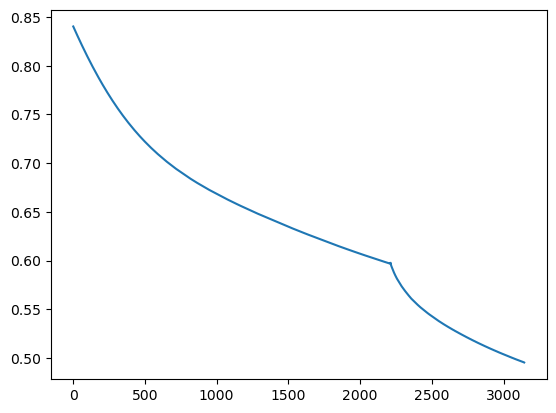

In [620]:
plt.plot(np.log10(history2['mse']))

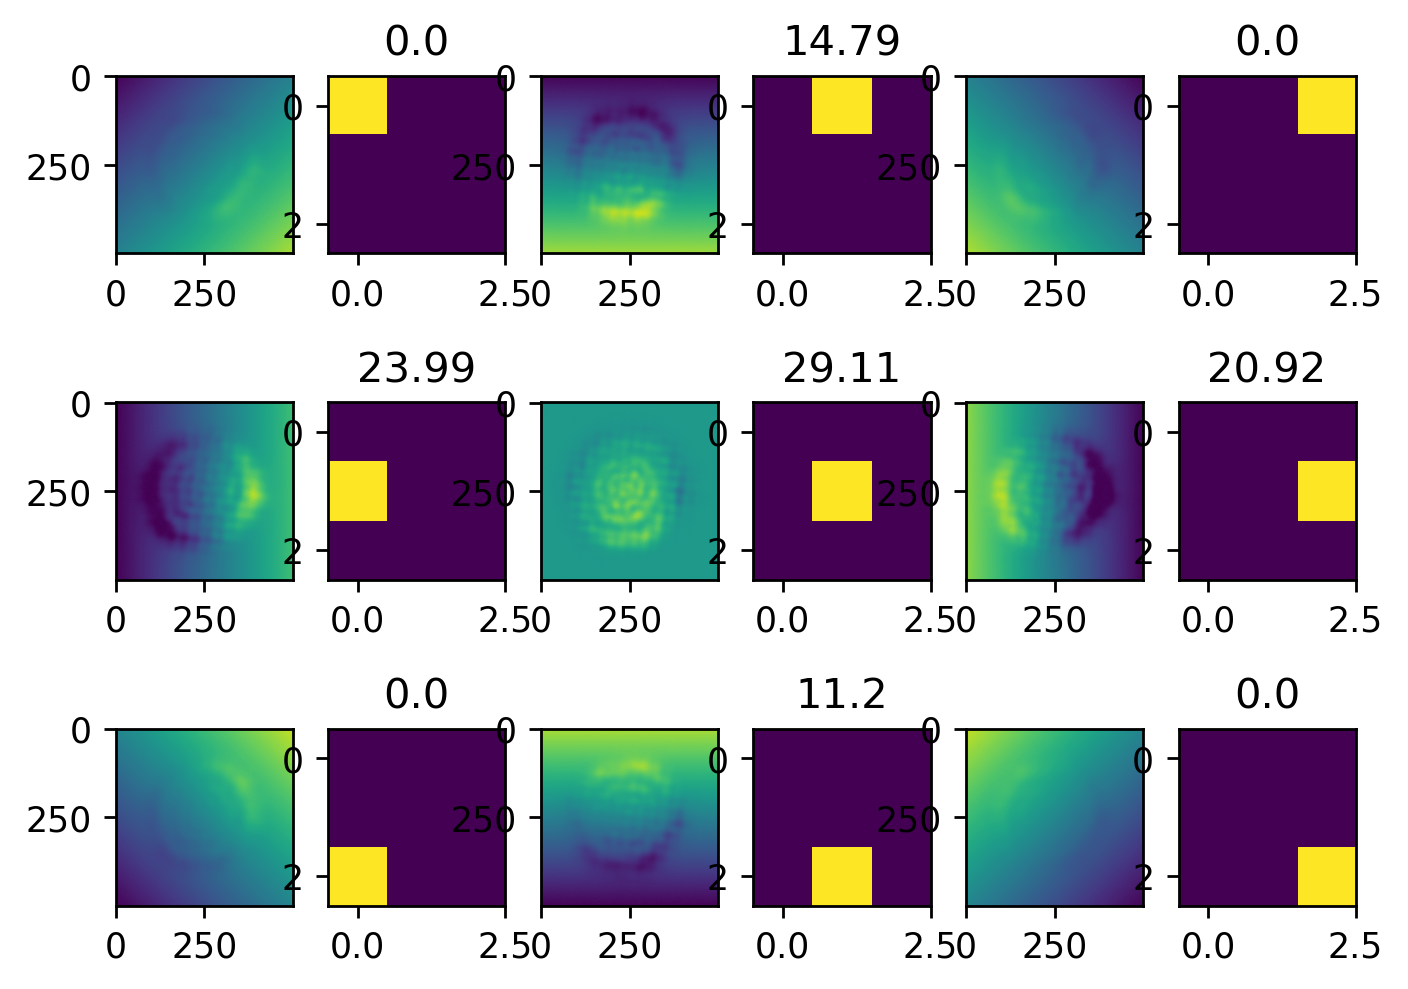

In [624]:
conv = [p for p in CG_conv.conv.parameters()][0]
maps,coeffs = [p for p in CG_conv.CG.parameters()][:2]


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * maps.mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3])
    ax[i,1].imshow(conv.cpu().detach()[i*3,0]); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))
    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1])
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0]); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))
    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2])
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0]); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))

### Try with FCN CG

In [756]:
history2= {}
history2['tl'] = []
history2['mse'] = []
history2['reg'] = []
history2['lr'] = []

In [757]:
kernelsize = 3
CG_channels = 9

final_prediction = final_prediction / final_prediction.mean()
mask_funda_wl = mask_funda_wl / mask_funda_wl.mean()

CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='pos',encoding_layers = 2,locally_connected=True).to(device)

In [758]:
lr = 5e-3



epochs = 8000
init_reg_factor = 5e-3

wl=11

all_params = list(CG_conv.parameters())

optimizer = torch.optim.Adam(all_params, lr=lr)




In [759]:
list(CG_conv.conv.parameters())[1]

Parameter containing:
tensor([-0.1430,  0.3024, -0.3172, -0.2813,  0.0051, -0.2958,  0.3280,  0.2209,
         0.2242], device='cuda:1', requires_grad=True)

In [760]:



start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    # yhat = CG_conv(final_prediction[:,wl:wl+1])
    yhat = torch.concat([CG_conv(final_prediction[:,i:i+1]) for i in range(final_prediction.shape[1])],dim=1)


    mse = loss_fn(yhat,mask_funda_wl)
    loss =  mse 

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for p in CG_conv.CG.conv.parameters():
            p.clamp_(min=0)
            


    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g} epoch time: {total_time_sec:5.5g}',end='\r')


    history2['tl'].append(train_loss)
    history2['mse'].append(mse.data.item())
    history2['reg'].append(init_reg_factor)
    history2['lr'].append(lr)


KeyboardInterrupt: 

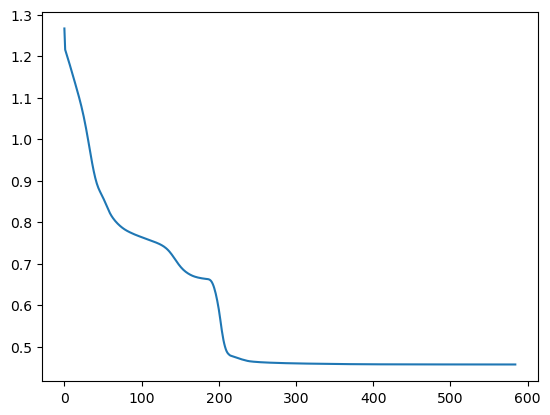

In [761]:
plt.plot(np.log10(history2['mse']))

In [762]:
CG_conv.conv

Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [763]:
coeffs.min()

tensor(0., device='cuda:1', grad_fn=<MinBackward1>)

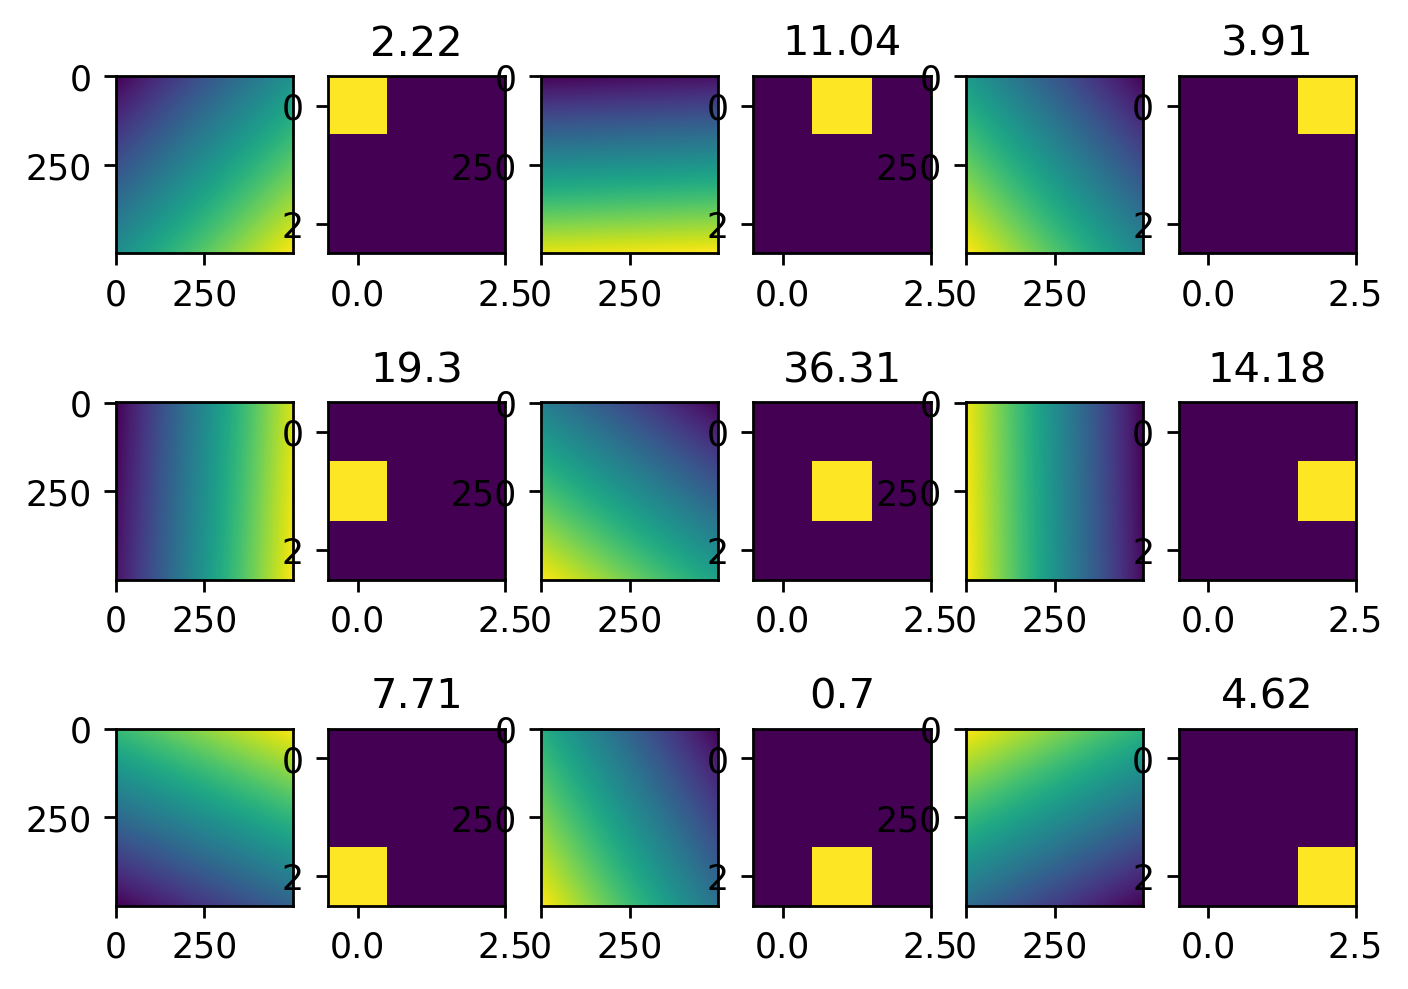

In [764]:
conv = [p for p in CG_conv.conv.parameters()][0]
maps = CG_conv.CG.encoder(CG_conv.CG.pos).view(1,500,500,9).permute(0,3,1,2)
coeffs = CG_conv.CG.conv.weight
# maps,coeffs = [p for p in CG_conv.CG.parameters()][:2]


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * torch.relu(maps).mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3])
    ax[i,1].imshow(conv.cpu().detach()[i*3,0]); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))
    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1])
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0]); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))
    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2])
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0]); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))

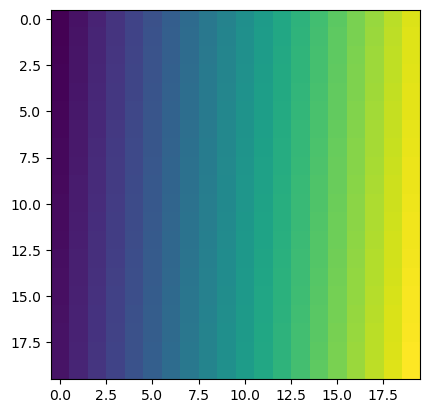

In [765]:
plt.imshow(maps[0,3,230:250,240:260].cpu().detach())

In [790]:
CG_channels = 9
kernelsize = 3



# initialiser = torch.rand((1,CG_channels,mask_nograting_funda.shape[2],mask_nograting_funda.shape[3]))
initialiser = torch.ones((1,CG_channels,mask_funda.shape[2],mask_funda.shape[3]))
initialiser = initialiser / CG_channels

CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=True, three_d=False).to(device) 


In [791]:
CG_conv.CG.map.data = maps

In [792]:
lr = 5e-2
optimizer = torch.optim.Adam(CG_conv.CG.parameters(), lr=lr)
init_reg_factor = 5e-5

tensor(7.6210, device='cuda:1', grad_fn=<MeanBackward0>)

In [798]:
start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    yhat = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(final_prediction.shape[1])],dim=1)



    reg1 = hessian(CG_conv.CG.map,norm=1)
    reg2 = torch.mean(torch.norm(CG_conv.CG.map,dim=(1),p=1))


    reg = reg1 + reg2


    mse = loss_fn(yhat,batch_y)
    loss =  mse + reg * init_reg_factor

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for n,parameter in enumerate(CG_conv.parameters()):
            # parameter.clamp_(min=0)
            if n!=2:
                # parameter.clamp_(min=0,max=1)
                parameter.clamp_(min=0)
            # else:
                # parameter.clamp_(max=1)

    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')


    history2['tl'].append(train_loss)
    history2['mse'].append(mse.data.item())
    history2['reg'].append(init_reg_factor)
    history2['lr'].append(lr)

KeyboardInterrupt: 

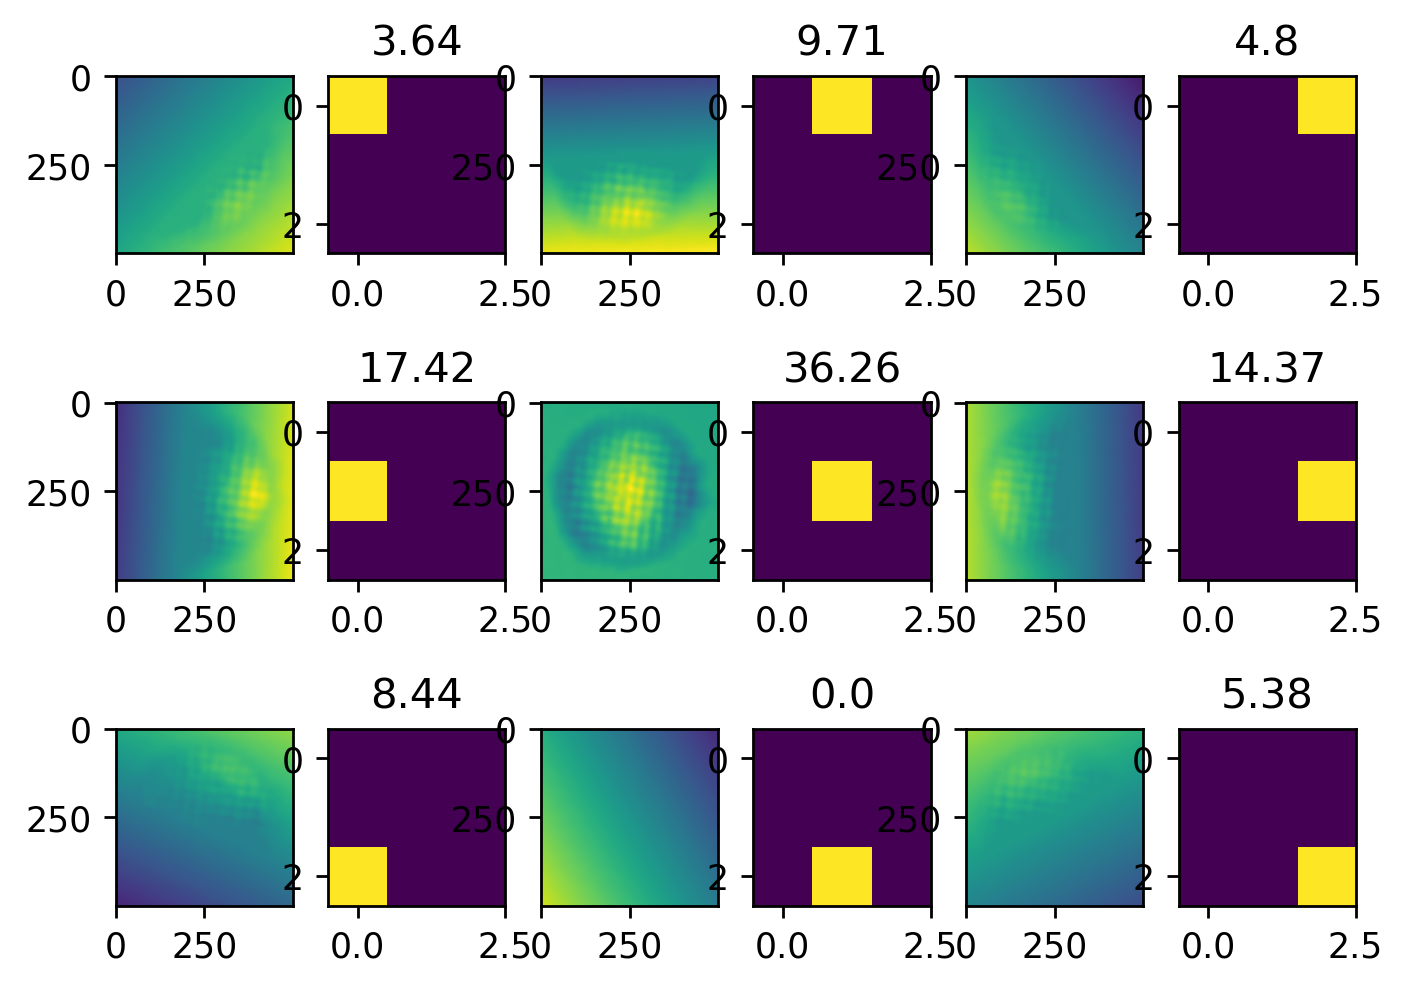

In [799]:
conv = [p for p in CG_conv.conv.parameters()][0]
maps,coeffs = [p for p in CG_conv.CG.parameters()][:2]


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * torch.relu(maps).mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3])
    ax[i,1].imshow(conv.cpu().detach()[i*3,0]); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))
    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1])
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0]); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))
    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2])
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0]); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))

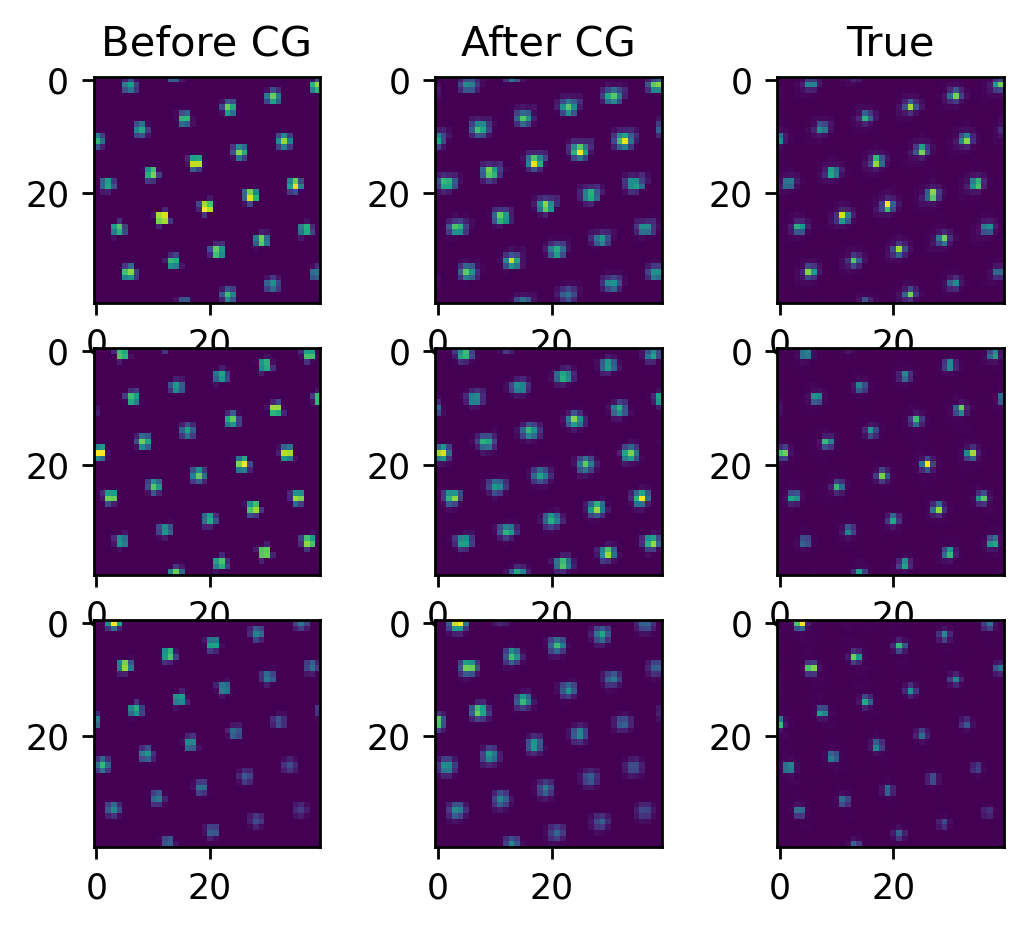

In [784]:
fig,ax = plt.subplots(3,3   ,figsize=(5,4),dpi=250)
ax[0,0].imshow(final_prediction.cpu()[0,wl,160:200,160:200]);ax[0,0].set_title('Before CG')
ax[0,1].imshow(yhat[0,0,160:200,160:200].detach().cpu());ax[0,1].set_title('After CG')
ax[0,2].imshow(mask_funda_wl[0,wl,160:200,160:200].detach().cpu());ax[0,2].set_title('True')
ax[1,0].imshow(final_prediction.cpu()[0,10,260:300,260:300])
ax[1,1].imshow(yhat[0,0,260:300,260:300].detach().cpu())
ax[1,2].imshow(mask_funda_wl[0,wl,260:300,260:300].detach().cpu())
ax[2,0].imshow(final_prediction.cpu()[0,wl,360:400,360:400])
ax[2,1].imshow(yhat[0,0,360:400,360:400].detach().cpu())
ax[2,2].imshow(mask_funda_wl[0,wl,360:400,360:400].detach().cpu())

Now can we correct for psf?

In [537]:
distortion_corrected = yhat.detach().clone()

In [585]:
batch_x = torch.zeros((1,distortion_corrected.shape[1],distortion_corrected.shape[2],distortion_corrected.shape[3])).to(device)
batch_y = torch.zeros((1,distortion_corrected.shape[1],distortion_corrected.shape[2],distortion_corrected.shape[3])).to(device)

for i in range(1):
    x = i//4
    y = i%4
    batch_x[i] = torch.roll(distortion_corrected[0],(x,y),(1,2))
    batch_y[i] = torch.roll(mask_funda_wl[0],(x,y),(1,2))



In [589]:
CG_channels = 6
kernelsize = 5

# initialiser = torch.rand((1,CG_channels,mask_nograting_funda.shape[2],mask_nograting_funda.shape[3]))
initialiser = torch.ones((1,CG_channels,mask_funda.shape[2],mask_funda.shape[3]))
initialiser = initialiser / CG_channels

CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=False, three_d=False).to(device) 

optimizer = torch.optim.Adam(CG_conv.parameters(), lr=1e-3)

init_reg_factor = 1e-5

In [590]:
start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    yhat = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(final_prediction.shape[1])],dim=1)



    reg = hessian(CG_conv.CG.map,norm=1)


    mse = loss_fn(yhat,batch_y)
    loss =  mse  + reg * init_reg_factor

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for n,parameter in enumerate(CG_conv.parameters()):
            # parameter.clamp_(min=0)
            if n!=2:
                # parameter.clamp_(min=0,max=1)
                parameter.clamp_(min=0)
            # else:
                # parameter.clamp_(max=1)

    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')


    history2['tl'].append(train_loss)
    history2['mse'].append(mse.data.item())
    history2['reg'].append(init_reg_factor)
    history2['lr'].append(lr)

KeyboardInterrupt: 

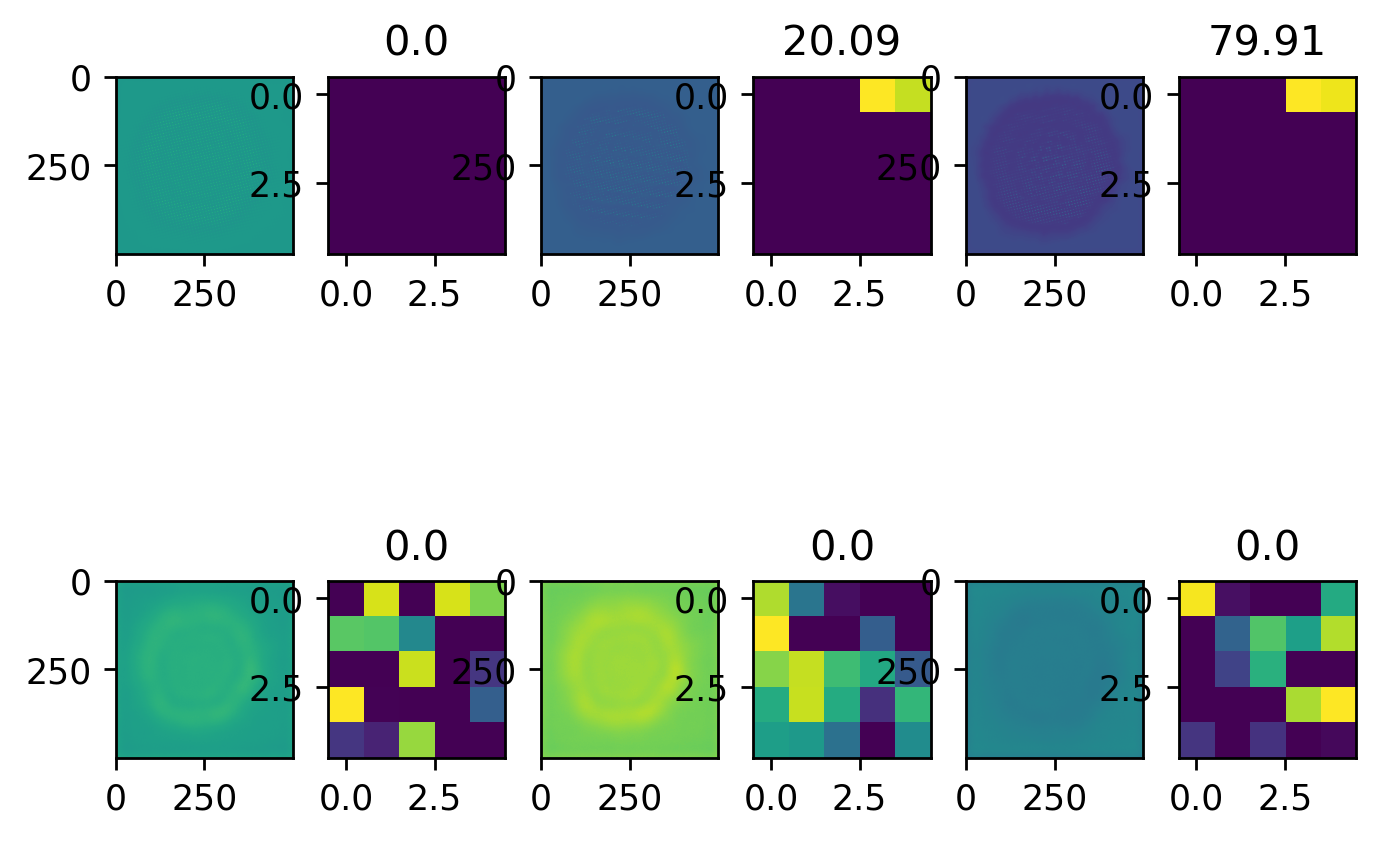

In [591]:
conv = [p for p in CG_conv.conv.parameters()][0]
maps,coeffs = [p for p in CG_conv.CG.parameters()][:2]


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * maps.mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()


plot_no = 2
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3])
    ax[i,1].imshow(conv.cpu().detach()[i*3,0]); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))
    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1])
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0]); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))
    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2])
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0]); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))